# A playground to understand the effect of tempering 

Here we try different things. The main idea is that we operate on a simple scenario and test different aspects of the code in a controlled environment.


In [1]:
## Load standard modules
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex']=True
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm
import sys, copy, copy, glob, pickle
from matplotlib.lines import Line2D

sys.path.append('../')
from eryn.state import State
from eryn.backends.backend import Backend
from eryn.ensemble import EnsembleSampler
from eryn.prior import uniform_dist
from eryn.moves import GaussianMove

import numpy as np

%load_ext autoreload
%autoreload 2

# seed our random number generator, so we have reproducible data
np.random.seed(sum([ord(v) for v in 'gaussians']))

## Make some data

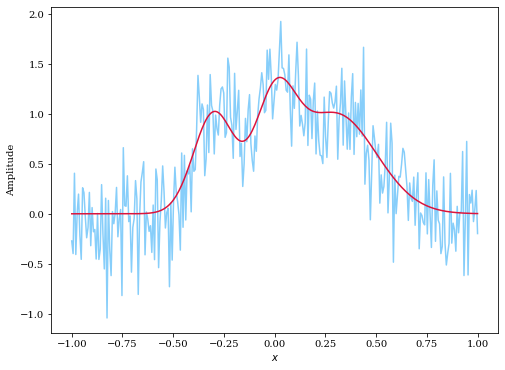

In [2]:
def gaussian(x, a, b, c):
    f_x = a[:, None] * np.exp(-((x[None, :] - b[:, None]) ** 2) / (2 * c[:, None] ** 2))
    return f_x


def gaussian_flat(x, a, b, c):
    f_x = a * np.exp(-((x - b) ** 2) / (2 * c ** 2))
    return f_x


def log_prob_fn(x1, group1, t, data, inds=None, fill_inds=[], fill_values=None):

    # gauss
    if len(fill_inds) > 0:
        raise NotImplementedError
        if fill_values is None:
            raise ValueError
        ndim = x1.shape[-1]
        ndim_total = ndim + len(fill_inds[0])
        base = x1.shape[:-1]
        x1_in = np.zeros(base + (ndim_total,))
        test_inds = np.delete(np.arange(ndim_total), fill_inds[0])
        x1_in[:, :, :, test_inds] = x1
        x1_in[:, :, :, fill_inds[0]] = fill_values[0]

    else:
        x1_in = x1

    a = x1_in[:, 0]
    b = x1_in[:, 1]
    c = x1_in[:, 2]

    gauss_out = gaussian(t, a, b, c)

    num_groups = group1.max() + 1

    template = np.zeros((num_groups, len(t)))
    for i in range(num_groups):
        inds1 = np.where(group1 == i)

        template[i] += gauss_out[inds1].sum(axis=0)
    # breakpoint()
    ll = - 0.5 * np.sum(((template - data) / sigma) ** 2, axis=-1)  #  / len(t)
    return ll

branch_names = ["gauss"]

num = 300
t = np.linspace(-1, 1, num)

gauss_inj_params = [
    [1.0, -0.3, 0.1],
    [1.0, -0.0, 0.1],
    [1.0, 0.3, 0.2],
]

injection = np.zeros(num)

for pars in gauss_inj_params:
    injection += gaussian_flat(t, *pars)

sigma = 0.3
y = injection + sigma * np.random.randn(len(injection))

plt.figure(figsize=(8,6))
plt.plot(t, y, label="data", color="lightskyblue")
plt.plot(t, injection, label="injection", color="crimson")
plt.xlabel(r'$x$')
plt.ylabel(r'Amplitude')
plt.show()
plt.close()

## Settings (priors, initial points, etc)

In [3]:

nwalkers    = 20
ntemps      = 1
ndims       = [3]
nleaves_max = [10]

priors = {
    "gauss": {
        0: uniform_dist(0.1, 5.),
        1: uniform_dist(t.min(), t.max()),
        2: uniform_dist(0.01, 0.3),
    },
}

coords = {
    name: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names)
}

sig1 = 0.0000001
for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names):
    for nn in range(nleaf):
        if nn >= len(gauss_inj_params):
            nn = np.random.randint(low=0, high=3)
        coords[name][:, :, nn] = np.random.multivariate_normal(gauss_inj_params[nn], np.diag(np.ones(3) * sig1), size=(ntemps, nwalkers))  


inds = {
     name: np.random.randint(low=0, high=1, size=(ntemps, nwalkers, nleaf), dtype=bool)
     for nleaf, name in zip(nleaves_max, branch_names)
}

inds['gauss'][:, :, :3] = True

for name, inds_temp in inds.items():
    inds_fix = np.where(np.sum(inds_temp, axis=-1) == 0)

    for ind1, ind2 in zip(inds_fix[0], inds_fix[1]):
        inds_temp[ind1, ind2, 0] = True

groups = {
    name: np.arange(coords[name].shape[0] * coords[name].shape[1]).reshape(
        coords[name].shape[:2]
    )[:, :, None]
    for name in coords
}

groups = {
    name: np.repeat(groups[name], coords[name].shape[2], axis=-1) for name in groups
}

coords_in = {name: coords[name][inds[name]] for name in coords}
groups_in = {name: groups[name][inds[name]] for name in groups}

log_prob = log_prob_fn(
    coords_in["gauss"],
    groups_in["gauss"],
    t,
    y,
    fill_inds=[],
    fill_values=None,
)

log_prob = log_prob.reshape(ntemps, nwalkers)
betas = np.linspace(1.0, 0.0, ntemps)

blobs = None  # np.random.randn(ntemps, nwalkers, 3)


## Sampler Settings 

In [4]:

state   = State(coords, log_prob=log_prob, betas=betas, blobs=blobs, inds=inds)
state2  = State(state)
backend = Backend()

backend.reset(
    nwalkers,
    ndims,
    nleaves_max=nleaves_max,
    ntemps=ntemps,
    truth=None,
    branch_names=branch_names,
    rj=True,
)

factor = 0.0001
cov    = {"gauss": np.diag(np.ones(3)) * factor}
moves  = GaussianMove(cov)

ensemble = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[t, y],
    tempering_kwargs=dict(betas=betas),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    provide_groups=True,
    moves=moves,
    plot_iterations=-1,
    rj_moves=True,
)

## Run

In [5]:
nsteps = 20000

ensemble.run_mcmc(state, nsteps, burn=10000, progress=True, thin_by=1)

check   = ensemble.backend.get_autocorr_time(average=True, all_temps=True)
testing = ensemble.get_nleaves()

100%|██████████| 20000/20000 [01:20<00:00, 248.56it/s]
../eryn/utils/utility.py:38: RuntimeWarning: invalid value encountered in true_divide
  return acf / acf[tuple(m)]


## Plot

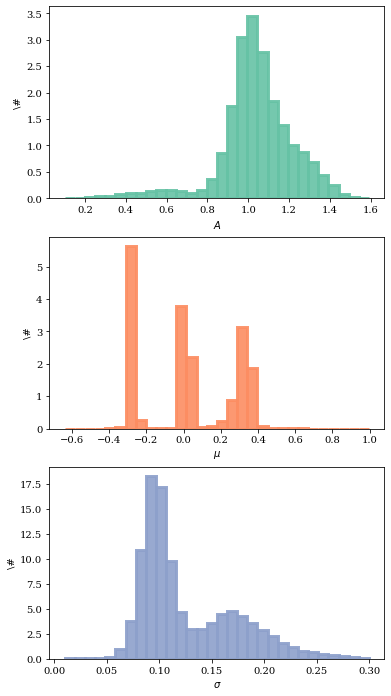

In [6]:
# betas 1d
# log_prob log_prior 2d with (ntemps, nwalkers)
# nleaves 2d (ntemps, nwalkers)
# inds 3d (ntemps, nwalkers, nleaves_max)
# coords (ntemps, nwalkers, nleaves_max, ndim)

clrs = plt.cm.Set2(np.linspace(0,1,9))

amp = ensemble.get_chain()["gauss"][:, 0, :, :, 0].flatten()
amp = amp[amp != 0.0]

mu = ensemble.get_chain()["gauss"][:, 0, :, :, 1].flatten()
mu = mu[mu != 0.0]

sig = ensemble.get_chain()["gauss"][:, 0, :, :, 2].flatten()
sig = sig[sig != 0.0]

fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharey=False, sharex=False)

axs[0].hist(amp, bins=30, density=True, color=clrs[0], edgecolor=clrs[0], alpha=0.9, lw=3)
axs[0].set_xlabel(r'$A$')
axs[0].set_ylabel(r'\#')

axs[1].hist(mu, bins=30, density=True, color=clrs[1], edgecolor=clrs[1], alpha=0.9, lw=3)
axs[1].set_xlabel(r'$\mu$')
axs[1].set_ylabel(r'\#')

axs[2].hist(sig, bins=30, density=True, color=clrs[2], edgecolor=clrs[2], alpha=0.9, lw=3)
axs[2].set_xlabel(r'$\sigma$')
axs[2].set_ylabel(r'\#')

plt.show()

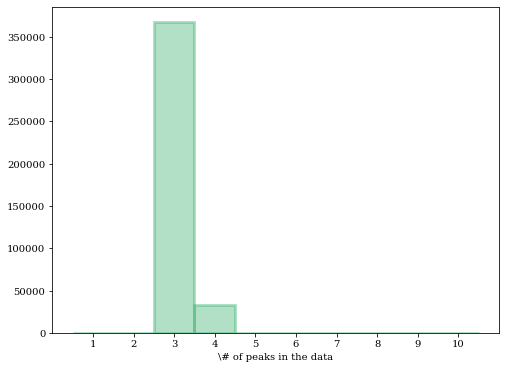

In [7]:
bns = (np.arange(1, nleaves_max[0] + 2) - 0.5)  # Just to make it pretty and center the bins

k_chain = testing["gauss"][:, 0].flatten()

plt.figure(figsize=(8,6))
plt.hist(k_chain, bins=bns, color='mediumseagreen', edgecolor='mediumseagreen', alpha=0.4, lw=3)
plt.xticks(np.arange(1, nleaves_max[0] + 1))
plt.xlabel(r"\# of peaks in the data")
plt.show()

## Repeat with tempered chains

In [8]:
ntemps      = 10 # <----- Choose the number of temps here

coords = {
    name: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names)
}

sig1 = 0.0000001
for nleaf, ndim, name in zip(nleaves_max, ndims, branch_names):
    for nn in range(nleaf):
        if nn >= len(gauss_inj_params):
            nn = np.random.randint(low=0, high=3)
        coords[name][:, :, nn] = np.random.multivariate_normal(gauss_inj_params[nn], np.diag(np.ones(3) * sig1), size=(ntemps, nwalkers))  


inds = {
     name: np.random.randint(low=0, high=1, size=(ntemps, nwalkers, nleaf), dtype=bool)
     for nleaf, name in zip(nleaves_max, branch_names)
}

inds['gauss'][:, :, :3] = True

for name, inds_temp in inds.items():
    inds_fix = np.where(np.sum(inds_temp, axis=-1) == 0)

    for ind1, ind2 in zip(inds_fix[0], inds_fix[1]):
        inds_temp[ind1, ind2, 0] = True

groups = {
    name: np.arange(coords[name].shape[0] * coords[name].shape[1]).reshape(
        coords[name].shape[:2]
    )[:, :, None]
    for name in coords
}

groups = {
    name: np.repeat(groups[name], coords[name].shape[2], axis=-1) for name in groups
}

coords_in = {name: coords[name][inds[name]] for name in coords}
groups_in = {name: groups[name][inds[name]] for name in groups}

log_prob = log_prob_fn(
    coords_in["gauss"],
    groups_in["gauss"],
    t,
    y,
    fill_inds=[],
    fill_values=None,
)

log_prob = log_prob.reshape(ntemps, nwalkers)
betas = np.linspace(1.0, 0.0, ntemps)

blobs = None  # np.random.randn(ntemps, nwalkers, 3)

nsteps = 20000

ensemble.run_mcmc(state, nsteps, burn=10000, progress=True, thin_by=1)

check   = ensemble.backend.get_autocorr_time(average=True, all_temps=True)
testing = ensemble.get_nleaves()

100%|██████████| 20000/20000 [01:15<00:00, 264.62it/s]


# Plot the thing

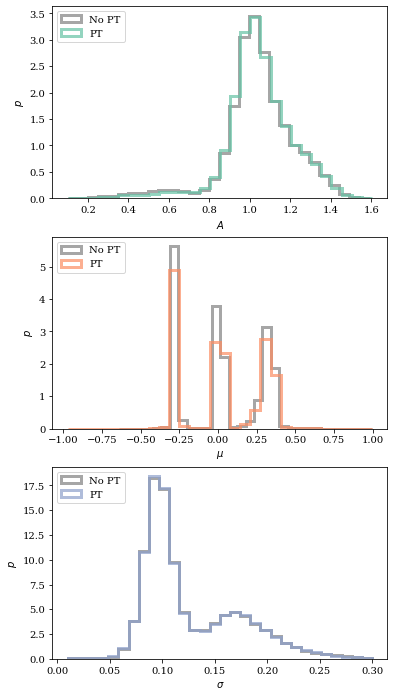

In [9]:
amp_t = ensemble.get_chain()["gauss"][:, 0, :, :, 0].flatten()
amp_t = amp_t[amp_t != 0.0]

mu_t = ensemble.get_chain()["gauss"][:, 0, :, :, 1].flatten()
mu_t = mu_t[mu_t != 0.0]

sig_t = ensemble.get_chain()["gauss"][:, 0, :, :, 2].flatten()
sig_t = sig_t[sig_t != 0.0]

fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharey=False, sharex=False)

axs[0].hist(amp, bins=30, density=True, histtype='step', color='grey', edgecolor='grey', alpha=0.7, lw=3, label='No PT')
axs[0].hist(amp_t, bins=30, density=True, histtype='step', color=clrs[0], edgecolor=clrs[0], alpha=0.7, lw=3, label='PT')
axs[0].set_xlabel(r'$A$')
axs[0].set_ylabel(r'$p$')
axs[0].legend(loc="upper left") # mode="expand"

axs[1].hist(mu, bins=30, density=True, histtype='step', color='grey', edgecolor='grey', alpha=0.7, lw=3, label='No PT')
axs[1].hist(mu_t, bins=30, density=True, histtype='step', color=clrs[1], edgecolor=clrs[1], alpha=0.7, lw=3, label='PT')
axs[1].set_xlabel(r'$\mu$')
axs[1].set_ylabel(r'$p$')
axs[1].legend(loc="upper left") # mode="expand"

axs[2].hist(sig, bins=30, density=True, histtype='step', color='grey', edgecolor='grey', alpha=0.7, lw=3, label='No PT')
axs[2].hist(sig_t, bins=30, density=True, histtype='step', color=clrs[2], edgecolor=clrs[2], alpha=0.7, lw=3, label='PT')
axs[2].set_xlabel(r'$\sigma$')
axs[2].set_ylabel(r'$p$')
axs[2].legend(loc="upper left") # mode="expand"

plt.show()

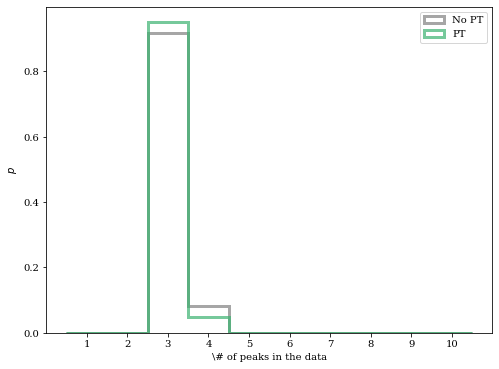

In [12]:
k_chain_t = testing["gauss"][:, 0].flatten()

plt.figure(figsize=(8,6))
plt.hist(k_chain, bins=bns, color='grey', histtype='step', density=True, alpha=0.7, lw=3, label='No PT')
plt.hist(k_chain_t, bins=bns, color='mediumseagreen', histtype='step', density=True, alpha=0.7, lw=3, label='PT')
plt.xticks(np.arange(1, nleaves_max[0] + 1))
plt.xlabel(r"\# of peaks in the data")
plt.ylabel(r"$p$")
plt.legend(loc="upper right")
plt.show()